## Energy forecast - Train simple models
We first train a simple linear model by using 8 hours of prices to predict the movement in next 5 hours.

In [36]:
seq_length = 8
n_forward = 5
my_model = "linear"

## Import libraries

In [37]:
import tensorflow as tf
from model import model

## Verify read_dataset method to read in training data

In [38]:
TIME_SERIES_INPUT = "prices"

with tf.Session() as sess:
    fn = model.read_dataset(filename="data/train_{}_{}.csv".format(seq_length, n_forward),
                            mode=tf.estimator.ModeKeys.TRAIN,
                            seq_length=seq_length,
                            n_forward=n_forward,
                            batch_size=1)

    batch_features, batch_labels = fn()
    features, labels = sess.run([batch_features, batch_labels])
    print("try_out_input_function: features shape = {}".format(features[TIME_SERIES_INPUT]))
    print("try_out_input_function: labels shape = {}".format(labels))

try_out_input_function: features shape = [[32.4  37.6  33.   33.85 33.35 39.3  36.22 32.4 ]]
try_out_input_function: labels shape = [[30.6  30.4  30.75 33.85 31.6 ]]


## Setup parameters

In [39]:
out_dir_str = "trained/{}".format(my_model)

hparams = {}
hparams['model'] = my_model
hparams['train_data_path'] = "data/train_{}_{}.csv".format(seq_length, n_forward)
hparams['eval_data_path'] = "data/eval_{}_{}.csv".format(seq_length, n_forward)
hparams['seq_length'] = seq_length
hparams['n_forward'] = n_forward
hparams['learning_rate'] = 0.2
hparams['train_steps'] = 2000
hparams['batch_size'] = 512
hparams['eval_delay_secs'] = 1
hparams['min_eval_frequency'] = 60

## Remove output folder so we can re-train the model

In [40]:
%%bash
OUTDIR=trained/linear
rm -rf $OUTDIR

## Train a linear model

In [41]:
model.train_and_evaluate(out_dir_str, hparams)

INFO:tensorflow:Using config: {'_task_type': 'worker', '_experimental_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e846c7048>, '_task_id': 0, '_protocol': None, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_service': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_train_distribute': None, '_evaluation_master': '', '_save_checkpoints_secs': 60, '_log_step_count_steps': 100, '_device_fn': None, '_eval_distribute': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_model_dir': 'trained/linear', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evalua

## Load trained model for prediction

We use the following 8 data points to test the prediction from trained model:

| Dates | Prices |
|-------|:------:|
|31/12/2015 11:00| 54 |
|31/12/2015 12:00| 53.3 |
|31/12/2015 13:00| 52.11 |
|31/12/2015 14:00| 51.2 |
|31/12/2015 15:00| 52.86 |
|31/12/2015 16:00| 56.7 |
|31/12/2015 17:00| 62.1 |
|31/12/2015 18:00| 63.44 |

Acutal subsequent prices to compare with predictions: 

| Dates | Prices |
|-------|:------:|
|31/12/2015 19:00| 63.29 |
|31/12/2015 20:00| 62.1 |
|31/12/2015 21:00| 56.7 |
|31/12/2015 22:00| 50.95 |
|31/12/2015 23:00| 48.55 |


In [42]:
SAVEDMODEL = "trained/linear/export/exporter/" + "1563258413"
predict_fn = tf.contrib.predictor.from_saved_model(SAVEDMODEL)

INFO:tensorflow:Restoring parameters from trained/linear/export/exporter/1563258413/variables/variables


In [43]:
import numpy as np
import pandas as pd
import seaborn as sns

Yin = np.array([[54, 53.3, 52.11, 51.2, 52.86, 56.7, 62.1, 63.44]])
r_linear = predict_fn({TIME_SERIES_INPUT: Yin})
predict_linear = r_linear['predicted'].squeeze()
print(predict_linear)

[63.946102 58.40284  60.23728  62.690014 57.09897 ]


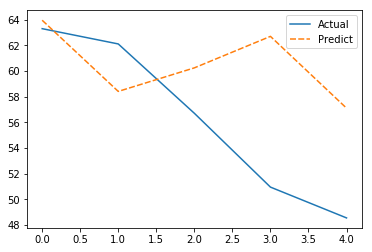

In [44]:
actual = np.array([63.29, 62.1, 56.7, 50.95, 48.55])
data = pd.DataFrame({'Actual':actual , 'Predict':predict_linear}) 
sns.lineplot(data=data)

## Train a simple DNN model

In [45]:
# setup parameters
my_model = "dnn"
out_dir_str = "trained/{}".format(my_model)
hparams['model'] = my_model

In [46]:
%%bash
OUTDIR=trained/dnn
rm -rf $OUTDIR

In [47]:
# train a DNN model
model.train_and_evaluate(out_dir_str, hparams)

INFO:tensorflow:Using config: {'_task_type': 'worker', '_experimental_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f7e8509a438>, '_task_id': 0, '_protocol': None, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_service': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_global_id_in_cluster': 0, '_keep_checkpoint_max': 5, '_train_distribute': None, '_evaluation_master': '', '_save_checkpoints_secs': 60, '_log_step_count_steps': 100, '_device_fn': None, '_eval_distribute': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_model_dir': 'trained/dnn', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate 

## Load DNN trained model for prediction

In [33]:
SAVEDMODEL = "trained/dnn/export/exporter/" + "1563258413"
predict_dnn_fn = tf.contrib.predictor.from_saved_model(SAVEDMODEL)

INFO:tensorflow:Restoring parameters from trained/dnn/export/exporter/1563258026/variables/variables


In [34]:
r_dnn = predict_fn({TIME_SERIES_INPUT: Yin})
predict_dnn = r_dnn['predicted'].squeeze()
print(predict_dnn)

[61.854984 62.461502 58.107456 62.900494 55.41546 ]


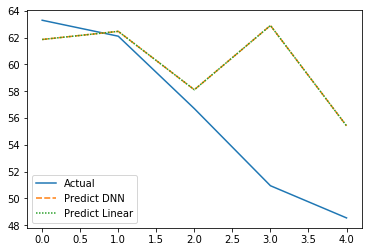

In [35]:
data = pd.DataFrame({'Actual':actual , 'Predict Linear':predict_linear, 'Predict DNN': predict_dnn}) 
sns.lineplot(data=data)